# Ipynb to 

graph and try out different 

ML concepts with a sample datasize.


A partir de las 3 tablas ya procesdas : 
* homeantennas
* sumlinks
* groundtruth

armames un datset para explorar conceptos de ML

In [1]:
## seteamos los parametros del notebook
%autosave 180
import pandas as pd; 
import numpy as np; 
import os;
import random;
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np; import os;import random;
import graphlab as gl
from IPython.display import display # para pretty-print con estetica ipython si es que estamos dentro de  un loop, if, etc
#esto es para dibujar directo a la notebook
gl.canvas.set_target('ipynb')

#seteamos el lugar de trabajo
HOMEDIR=os.path.expanduser('~')

PROJECTDIR = os.getcwd().split(os.sep)
PROJECTDIR =  os.sep.join(PROJECTDIR[:PROJECTDIR.index('mexico-scripts-ver2') + 1])

DATADIR = os.path.join(PROJECTDIR,'datasets')

DATADIR2 = os.path.join(PROJECTDIR,'data')
# os.chdir(DATADIR)


Autosaving every 180 seconds


In [2]:
!ls $DATADIR

data_balanced_sample.csv  gtruth_0215_0715  sl
gtruth_0114_0715	  homeant	    sl.csv.gz


In [3]:
graphlab_frame = False
# graphlab_frame = 'juan' in HOMEDIR

def get_input_sframe(ds,graphlab_frame=graphlab_frame):
    if graphlab_frame:
        if ds == 'home_antenna': url = DATADIR +"/homeant"
        elif ds == 'sum_links': url  = DATADIR +"/sl"
        elif ds == 'gtruth_02': url  = DATADIR +"/gtruth_0215_0715" # can be near ground truth (previous to july 2015)
        elif ds == 'gtruth_01': url  =  DATADIR +"/gtruth_0114_0715" # or can be old GT
        else: print('type chosen is %s, type should be home_antenna, sum_links, gtruth_02 or gtruth_01' % ds)
    else:
        url = DATADIR + '/data_balanced_sample.csv'
    return url 

In [4]:
#from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
#NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids, OverSampler, SMOTE,\
#SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

## decide if load a reduced size dataset

In [5]:
# set what is the resulting sample we want of the global dataset
global_split = 0.25
global_split = None

# since we have 2 datets that will be later joined and which are going to be previously sampled, in the end this 
# independent sampling will result in that, after the join, the dataset will have a size of fraction given by 
# the `global_split` variable
if global_split:
    
    seed = 2015
    sample = np.sqrt(global_split)
    print(sample)

In [6]:
%%time

if graphlab_frame:
    sf_table, _ = gl.load_sframe(get_input_sframe('home_antenna',graphlab_frame))
    sl_table, _ = gl.load_sframe(get_input_sframe('sum_links',graphlab_frame))
    # no need to sample the gt table since it is very small in memory
    gt_table = gl.load_sframe(get_input_sframe('gtruth_01',graphlab_frame))

    if global_split:

        sf_table, _ = sf_table.random_split(sample,seed=seed)
        sl_table, _ = sl_table.random_split(sample,seed=seed)


    rename_gt = (dict([(col,col+"_gt") for col in gt_table.column_names() if col != 'USER']))

    #agrego la etiqueta "_gt" a las columnas del ground_truth
    gt_table.rename(rename_gt) 
else:
    data = pd.read_csv(get_input_sframe('sum_links',graphlab_frame))

CPU times: user 3.91 s, sys: 120 ms, total: 4.03 s
Wall time: 4.79 s


In [7]:
if graphlab_frame:
    print(sf_table.shape, sl_table.shape, gt_table.shape)
else:
    print(data.shape)

(153010, 176)


## simple format description

Aca miramos las top 10 antenas que utilizo un usuario, ordeandas de 0 a 10 segun el uso, en numero de llamados, que el user le daba a c. antenna. _0_ Seria la antenna mas utilizada y _10_ la menos utilizada. El count es la cantidad de veces que utilizo esa antenna. 

Cuando aparece _WEEKNIGHT_ en el nombre de la columna, es porque cumple la condicion de que los llamados fueron hechos de noche fuera del horario [8,20] y dentro de la semana laboral.

Siguiendo las definiciones del trabajo de Caro, un user es _EPIDEMIC_ siii su ANTENNA_WEEKNIGHT_0 (esta es la home_antenna) pertence a la zona epidemica.

El mobility_diameter es el radio de las antennas (0 si uso una sola, etc.) utilizadas por este user. Nuevamente el modificador _WEEKNIGHT_ solo aplica para antennas utilizadas en esos horarios.

In [8]:
# column names
if graphlab_frame:
    print(sf_table.column_names())
else:
    print(data.columns)

Index([u'USER', u'COUNT_0', u'COUNT_1', u'COUNT_2', u'COUNT_3', u'COUNT_4',
       u'COUNT_5', u'COUNT_6', u'COUNT_7', u'COUNT_8',
       ...
       u'TimeWeekDay_IN_11', u'CallsWeekEnd_IN_11', u'TimeWeekNight_IN_11',
       u'TimeWeekEnd_IN_VUL_11', u'CallsWeekDay_IN_VUL_11',
       u'CallsWeekNight_IN_VUL_11', u'TimeWeekDay_IN_VUL_11',
       u'CallsWeekEnd_IN_VUL_11', u'TimeWeekNight_IN_VUL_11',
       u'VULNERABLE_IN_11'],
      dtype='object', length=176)


## sum links description

La tabla sum_links tiene mas atributos y con data mas rica en informacion:
    
Esencialmente para c/ user miramos la cantidad de llamados y el tiempo que duraron esos llamados pero segmentando con distintos modificadores. `Time` representa la duracion del llamado y Calls el conteo de llamados.

Los modficadores/ segmentaciones son:

* mes en el cual estamos parados (12 == diciembre, ..., 08 == agosto)
* OUT/IN, separa por la direccion de los llamados si salientes u entrantes.
* _VULN_ : separa los llamados que fueron realizados hacia/desde un target_user (en una llamada hay 2 usuarios, el origin o el target) viviendo en una zona epidemica. Donde la home antena de un target_user determina su vulnerabilidad segun si es zona epidemica o no.
* Weekend, WeekDay y WeekNight son lo que suenan. Weekend el finde, Weeknight la semana pero fuera de horario laboral y Weekday en horario laboral y de lunes a viernes.

Hay solo una columna que no entra enteramente en este esquema que es VULNERABLE. Esta columna hace un conteo p/c/ usuario d cuantos target_users viven en una zona epidemica. Tambien se segmenta esta columna con los modficiadores anteriores (el mes y el out/in).

In [9]:
# column names
if graphlab_frame:
    print(sl_table.column_names())

# Para la
tabla gt (ground_truth) es mas simple la explicacion. Solo se busco el antenna_ID_0 (nuevamente la antenna mas utilizada) por un user

In [10]:
if graphlab_frame:
    print(gt_table.head())

# We need antennas metadata
to get the epidemicity of each antenna and add that info to the dataset

In [11]:
DATADIR2

'/home/juan/mobility-study/mexico-scripts-ver2/data'

In [12]:
DATADIR

'/home/juan/mobility-study/mexico-scripts-ver2/datasets'

In [13]:
#agregamos al gt su info de epidemicidad
antennas_file = DATADIR2+'/celdas_limpio.csv'

if graphlab_frame:
    antennas = gl.SFrame.read_csv(antennas_file, 
                              delimiter= "|", 
                usecols=['LATITUDE','LONGITUDE','CEL_ID','STATE','EPIDEMIC'],
                column_type_hints=[float, float, str,str, bool]
                            )
else:
    antennas = pd.read_csv(antennas_file,sep='|')


In [14]:
%%time
# enriquecemos la data de gt con info de epidemicidad
if graphlab_frame:
    # agrego tambien data de epidemicidad al simpleformat table
    sf_table = sf_table.join(antennas['CEL_ID','EPIDEMIC','STATE'], 
                             on = {'ANTENNA_ID_WEEKNIGHT_0':'CEL_ID'},
                             how = 'left')
    gt_table = gt_table.join(antennas['CEL_ID','EPIDEMIC','STATE'], 
                             on = {'ANTENNA_ID_WEEKNIGHT_0_gt':'CEL_ID'},
                             how = 'left')

    gt_table.rename({'EPIDEMIC':'EPIDEMIC_gt'});

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


# create data matrix

In [15]:
%%time
if graphlab_frame:
    data = sl_table.join(gt_table['USER','EPIDEMIC_gt'], on = 'USER', how = 'inner')
    data = data.join(sf_table, on = 'USER', how = 'inner')
    #no podemos tener nulls en el target asi que dropeamos
    data = data.dropna(columns = ['EPIDEMIC_gt'], how='any')
    del sl_table, sf_table, gt_table

print(data.shape)


(153010, 176)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 718 µs


In [16]:
data['EPIDEMIC_gt'].sum(),data['EPIDEMIC'].sum()

(51709, 47344)

In [17]:
# data.query('EPIDEMIC==0  ').STATE.value_counts()

## preparamos los datasets que no pueden tomar valores negativos o categorical vars

# train test split as 
p% of set as validation and the resulting  as train

In [18]:
split_perc = 0.9
mask = np.random.rand(data.shape[0])< split_perc

val_set = data[mask==0]
data = data[mask==1]


## define our real X variable and Y vars

exclude/include features. Decide our problem (multi-target, single_target)

## in our  X features..

determine which columns have no meaning.

we are going to try different models

In [20]:
if graphlab_frame: iterable=data.column_names()
else: iterable=data.columns

manual_exclude_cols = [     
#     'EPIDEMIC',
#      'EPIDEMIC_gt',
#       'STATE',
                ]

comprehensive_exclude_cols = [col for col in iterable if col == 'USER' 
          or ('ANTENNA' in col) ]   
                                
exclude_cols = manual_exclude_cols + comprehensive_exclude_cols
exclude_cols

['USER',
 'ANTENNA_ID_0',
 'ANTENNA_ID_1',
 'ANTENNA_ID_2',
 'ANTENNA_ID_3',
 'ANTENNA_ID_4',
 'ANTENNA_ID_5',
 'ANTENNA_ID_6',
 'ANTENNA_ID_7',
 'ANTENNA_ID_8',
 'ANTENNA_ID_9',
 'ANTENNA_ID_WEEKNIGHT_0',
 'ANTENNA_ID_WEEKNIGHT_1',
 'ANTENNA_ID_WEEKNIGHT_2',
 'ANTENNA_ID_WEEKNIGHT_3',
 'ANTENNA_ID_WEEKNIGHT_4',
 'ANTENNA_ID_WEEKNIGHT_5',
 'ANTENNA_ID_WEEKNIGHT_6',
 'ANTENNA_ID_WEEKNIGHT_7',
 'ANTENNA_ID_WEEKNIGHT_8',
 'ANTENNA_ID_WEEKNIGHT_9']

## first our Y vars

define them with a set of different possible cases/problems to solve

In [25]:
case = 5

## people that used to live in the endemic area
if case ==0:
    case_text = "people that used to live in the endemic area"
    Y = data['EPIDEMIC_gt'] == 1
    Y_val = val_set['EPIDEMIC_gt'] == 1

## people that used to live in the endemic area *and* migrated
if case ==1:
    case_text = "people that used to live in the endemic area *and* migrated"
    Y = (data['EPIDEMIC_gt'] ==1) & (data['EPIDEMIC'] ==0)
    Y_val = (val_set['EPIDEMIC_gt'] ==1) & (val_set['EPIDEMIC'] ==0)
    add_exclusion_cols = ['EPIDEMIC','STATE']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

## people that migrated in any direction
if case ==2:
    case_text = "people that migrated in any direction"
    Y = data['EPIDEMIC_gt'] != data['EPIDEMIC']
    Y_val = val_set['EPIDEMIC_gt'] != data['EPIDEMIC']
    
    add_exclusion_cols = []

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

    
## people that migrated in any direction
if case ==3:
    case_text = "currently non_endemic, that used to live in the endemic area"
    
    data = data[data['EPIDEMIC'] ==0]
    val_set = val_set[val_set['EPIDEMIC'] ==0]

    Y = (data['EPIDEMIC_gt'] ==1)
    Y_val = (val_set['EPIDEMIC_gt'] ==1) 
    
    add_exclusion_cols = ['EPIDEMIC']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]
    

    
## people from the Mexico or DF states
if case == 4:
    case_text = "people from the Mexico or DF states"
    Y = (data['STATE'] == 'Distrito_Federal') | (data['STATE'] == 'Mexico')
    Y_val = (val_set['STATE'] == 'Distrito_Federal') | (val_set['STATE'] == 'Mexico')
    
    add_exclusion_cols = ['EPIDEMIC','STATE']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]
            
## people from the Mexico or DF states
if case == 4:
    case_text = "people from the Mexico or DF states"
    Y = (data['STATE'] == 'Distrito_Federal') | (data['STATE'] == 'Mexico')
    Y_val = (val_set['STATE'] == 'Distrito_Federal') | (val_set['STATE'] == 'Mexico')
    
    add_exclusion_cols = ['EPIDEMIC','STATE']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]
            
## people with a HIGH present mobility (>1000 after looking at percentiles of the MOBILITY_DIAMTER)
if case == 5:
    val = 1000
    case_text = "people with a high mobility during present time (values > {} )".format(val)
    Y = (data['MOBILITY_DIAMETER'] > val) 
    Y_val = (val_set['MOBILITY_DIAMETER'] > val) 
    
    add_exclusion_cols = ['MOBILITY_DIAMETER_WEEKNIGHT',
                          'MOBILITY_DIAMETER']

    for col in add_exclusion_cols:
        if not col in exclude_cols:
            exclude_cols+=[col]

In [26]:
if graphlab_frame: iterable=data.column_names()
else: iterable=data.columns

In [27]:
width = 30
N= np.random.randint(1,int(iterable.shape[0]*1.0/width))
data.columns[(N)*width: (N+1)*width]

Index([u'TimeWeekNight_IN_08', u'TimeWeekEnd_IN_VUL_08',
       u'CallsWeekDay_IN_VUL_08', u'CallsWeekNight_IN_VUL_08',
       u'TimeWeekDay_IN_VUL_08', u'CallsWeekEnd_IN_VUL_08',
       u'TimeWeekNight_IN_VUL_08', u'VULNERABLE_IN_08', u'TimeWeekEnd_OUT_09',
       u'CallsWeekDay_OUT_09', u'CallsWeekNight_OUT_09', u'TimeWeekDay_OUT_09',
       u'CallsWeekEnd_OUT_09', u'TimeWeekNight_OUT_09',
       u'TimeWeekEnd_OUT_VUL_09', u'CallsWeekDay_OUT_VUL_09',
       u'CallsWeekNight_OUT_VUL_09', u'TimeWeekDay_OUT_VUL_09',
       u'CallsWeekEnd_OUT_VUL_09', u'TimeWeekNight_OUT_VUL_09',
       u'VULNERABLE_OUT_09', u'TimeWeekEnd_IN_09', u'CallsWeekDay_IN_09',
       u'CallsWeekNight_IN_09', u'TimeWeekDay_IN_09', u'CallsWeekEnd_IN_09',
       u'TimeWeekNight_IN_09', u'TimeWeekEnd_IN_VUL_09',
       u'CallsWeekDay_IN_VUL_09', u'CallsWeekNight_IN_VUL_09'],
      dtype='object')

In [28]:
%%time

X = data[[col for col in iterable if col not in exclude_cols]]

X_val = val_set[[col for col in iterable if col not in exclude_cols]]

if graphlab_frame: iterable=X.column_names()
else: iterable=X.columns
    
# clean negative/Null vals in count cols 
for col in [col for col in iterable if 'COUNT' in col]:
    X[col]= X[col].apply(lambda x :  x if x>=0 else 0)
    X_val[col]= X_val[col].apply(lambda x :  x if x>=0 else 0)



/home/juan/mfixman/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/juan/mfixman/venv/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


CPU times: user 3.36 s, sys: 52 ms, total: 3.41 s
Wall time: 3.4 s


In [29]:
X.shape, Y.shape

((94908, 152), (94908,))

## dummy-ize categorical cols
if necessary

In [30]:
if graphlab_frame: iterable=X.column_names()
else: iterable=X.columns


In [31]:
# X.columns
# [col for col in X.columns if 'STATE' in col]
# [col for col in X_val.columns if 'STATE' in col]

In [32]:
categorical_cols = [
    'STATE'
]

In [33]:
for col in categorical_cols:
    if col not in exclude_cols:
        print('we are categorizing col %s' %col)
        X[col] = X[col].astype('category')
    #     if X[col].dtype != 'category':
    #         continue 
        X = pd.concat([X,pd.get_dummies(X[col], 
                                          prefix= col, 
                                          prefix_sep='_', 
                                          #sparse = True,
                                          dummy_na=False).astype(np.int8)],\
                  axis=1 ,join = 'inner')
        X.drop(col, axis =1 , inplace=True)

        # now onto test_table
        X_val[col] = X_val[col].astype('category')
        X_val = pd.concat([X_val,pd.get_dummies(X_val[col], 
                                          prefix= col, 
                                          prefix_sep='_', 
                                          #sparse = True,
                                          dummy_na=False).astype(np.int8)],\
                  axis=1 ,join = 'inner')

        X_val.drop(col, axis =1 , inplace=True)


we are categorizing col STATE


/home/juan/mfixman/venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/juan/mfixman/venv/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## explore correlations to target var

with current column configuration

In [34]:
corr = pd.DataFrame(X).copy()
target_col = 'target'
corr[target_col] = Y
corr = corr.corr()
corr.shape

(176, 176)

In [36]:
view = corr.query('target>0.1')
# show only those columns which 
corr_columns = view.index.values

view[corr_columns].head(10)

,STATE_Baja_California,STATE_Queretaro,STATE_San_Luis_Potosi,STATE_Sonora,target
STATE_Baja_California,1.000000,-0.017934,-0.016483,-0.007726,0.127676
STATE_Queretaro,-0.017934,1.000000,-0.022644,-0.010614,0.153906
STATE_San_Luis_Potosi,-0.016483,-0.022644,1.000000,-0.009755,0.116226
STATE_Sonora,-0.007726,-0.010614,-0.009755,1.000000,0.103256
target,0.127676,0.153906,0.116226,0.103256,1.000000


In [37]:
## show correlation between state and target

if not 'STATE' in exclude_cols:    
    state_cols = [col for col in corr if 'STATE' in col]
    view = corr[state_cols + [target_col]]
    display(view.query('target > 0.01'))


,STATE_Aguascalientes,STATE_Baja_California,STATE_Baja_California_Sur,STATE_Campeche,STATE_Chiapas,STATE_Chihuahua,STATE_Coahuila_de_Zaragoza,STATE_Colima,STATE_Distrito_Federal,STATE_Durango,...,STATE_Queretaro,STATE_Quintana_Roo,STATE_San_Luis_Potosi,STATE_Sinaloa,STATE_Sonora,STATE_Tamaulipas,STATE_Tlaxcala,STATE_Yucatan,STATE_Zacatecas,target
COUNT_4,0.015422,0.001602,0.003505,0.010769,0.008543,0.016636,0.000749,0.025387,-0.006302,0.004299,...,0.006694,0.018451,0.028111,0.009248,0.003782,-0.005369,-0.032632,0.001645,-0.002545,0.011123
COUNT_5,0.015122,-0.000782,0.002857,0.007378,0.007986,0.013513,0.000626,0.020948,0.002615,0.001754,...,0.008044,0.018399,0.031331,0.007061,0.003804,-0.004907,-0.039382,0.003054,-0.007262,0.010804
COUNT_6,0.013111,-0.004074,0.002370,0.002411,0.004554,0.012395,-0.000897,0.016001,0.013542,0.001902,...,0.009141,0.013247,0.031002,0.005153,0.003519,-0.006584,-0.044203,0.005368,-0.013183,0.010159
COUNT_9,0.008391,-0.006055,-0.002987,-0.016655,-0.006139,0.010632,-0.007672,-0.000099,0.046955,-0.005287,...,0.012302,0.003251,0.028411,0.001712,0.004875,-0.012373,-0.055822,0.012369,-0.025333,0.010126
COUNT_WEEKNIGHT_2,0.001023,0.019836,0.013476,0.013709,0.001846,0.013493,0.001177,0.025956,0.023920,0.001079,...,0.005095,-0.002858,0.011356,0.018042,0.008895,-0.008709,-0.028948,0.001291,0.002602,0.016457
COUNT_WEEKNIGHT_3,0.000484,0.012457,0.012997,0.012674,-0.003586,0.010712,-0.000919,0.024227,0.040197,0.000384,...,0.010095,-0.003470,0.016843,0.019477,0.010158,-0.009758,-0.035695,0.004161,-0.004603,0.016668
COUNT_WEEKNIGHT_4,-0.000310,0.010059,0.012839,0.005840,-0.005604,0.007533,-0.005529,0.017324,0.058508,-0.001669,...,0.011400,-0.005128,0.017099,0.018122,0.010672,-0.012397,-0.042641,0.006001,-0.007769,0.019763
COUNT_WEEKNIGHT_5,-0.000126,0.008736,0.009372,-0.000562,-0.008691,0.004769,-0.008345,0.012420,0.073662,-0.001731,...,0.011238,-0.009260,0.017514,0.013264,0.010178,-0.013367,-0.048567,0.006312,-0.012883,0.020352
COUNT_WEEKNIGHT_6,-0.002736,0.003839,0.007955,-0.006482,-0.011501,0.003809,-0.010962,0.008471,0.087384,-0.003903,...,0.011750,-0.013108,0.016312,0.012438,0.010575,-0.015707,-0.053174,0.007146,-0.016662,0.020137
COUNT_WEEKNIGHT_7,-0.005012,0.003016,0.004801,-0.012906,-0.015158,0.001968,-0.011869,0.002554,0.100582,-0.006756,...,0.011727,-0.017270,0.015085,0.009963,0.009642,-0.020377,-0.056635,0.006926,-0.020681,0.020059


In [40]:
a=data['EPIDEMIC_gt'].sum();b= data.shape[0]
a*1.0/b

0.19847641926918699

In [41]:
a=val_set['EPIDEMIC'].sum();b= val_set.shape[0]
a*1.0/b

0.0

In [42]:
# cast to numpy types if necessary
# %%time
# X = X.to_dataframe()
# Y = pd.Series(data=Y.to_numpy(),dtype=np.bool,name = 'EPIDEMIC_gt')
# X_val = X_val.to_dataframe()
# Y_val = pd.Series(data=Y_val.to_numpy(),dtype=np.bool,name = 'EPIDEMIC_gt')

# Instance fast model with MNB
#### convertimos la data en numpy, previamente limpiando las columnas de antennas ya que el clasificador no acepta strings

In [43]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import *
from sklearn.metrics import *
# from sklearn.cross_validation import *
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     train_test_split, KFold, cross_val_predict, 
                                     cross_val_score, learning_curve, validation_curve
                                    )

This non-commercial license of GraphLab Create for academic use is assigned to jdemonasterio@dc.uba.ar and will expire on May 06, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1496668467.log


## remember the Multinomail NB assumes no negative values
are present in the dataset as this must be `count` data

In [44]:
%%time
start_time = time.time()
param_grid = {'alpha':[1e-3, 1e-1, 1e1,1e0], 'fit_prior': [True,False],
             }

mnb  = MultinomialNB( )

clf = GridSearchCV(mnb, param_grid, scoring='f1_weighted', fit_params=None, n_jobs=-1, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf2 = MultinomialNB( )
#how many parameters to randomly search for
#n_iter_search = 45

#random_search = RandomizedSearchCV(rforest, param_distributions=param_grid,
                                 #  n_iter=n_iter_search, n_jobs =8, verbose=3)

elapsed_time =  time.time() - start_time

#Y = categorical(train_table_target.values, drop=True).astype(int)

clf.fit(X,Y)

elapsed_time =   time.time() - start_time 

print('Grid Search took %s seconds to run' % (elapsed_time))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1


#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('\n Best estimator was %s \n' % str(clf.best_estimator_))
print('\n Best estimator was %s \n' % str(clf.best_score_))

clf2.set_params(**clf.best_params_)

clf2.fit(X,Y)


#converted_dict = evaluation_print(clf, X_val, test_table_target.values, test_table.index.values, 
#                              test_table_target[test_table_target>0].index.values,start_date,future)

print(classification_report(Y_val,clf2.predict(X_val)))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=0.001, fit_prior=True .....................................
[CV] alpha=0.001, fit_prior=True .....................................
[CV] alpha=0.001, fit_prior=True .....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.704388, total=   0.4s
[CV] alpha=0.001, fit_prior=False ....................................
[CV] ...... alpha=0.001, fit_prior=True, score=0.768092, total=   0.4s
[CV] alpha=0.001, fit_prior=False ....................................


[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    1.2s remaining:   13.1s


[CV] ...... alpha=0.001, fit_prior=True, score=0.768343, total=   0.4s
[CV] alpha=0.001, fit_prior=False ....................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.700921, total=   0.4s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.768012, total=   0.4s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ..... alpha=0.001, fit_prior=False, score=0.768308, total=   0.4s
[CV] alpha=0.1, fit_prior=True .......................................
[CV] ........ alpha=0.1, fit_prior=True, score=0.704388, total=   0.4s
[CV] alpha=0.1, fit_prior=False ......................................
[CV] ........ alpha=0.1, fit_prior=True, score=0.768092, total=   0.4s
[CV] alpha=0.1, fit_prior=False ......................................
[CV] ........ alpha=0.1, fit_prior=True, score=0.768343, total=   0.5s
[CV] alpha=0.1, fit_prior=False ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    3.4s remaining:    4.1s


[CV] ....... alpha=0.1, fit_prior=False, score=0.768308, total=   0.4s
[CV] alpha=10.0, fit_prior=True ......................................
[CV] ....... alpha=10.0, fit_prior=True, score=0.704269, total=   0.4s
[CV] alpha=10.0, fit_prior=False .....................................
[CV] ....... alpha=10.0, fit_prior=True, score=0.768092, total=   0.4s
[CV] alpha=10.0, fit_prior=False .....................................
[CV] ....... alpha=10.0, fit_prior=True, score=0.768323, total=   0.4s
[CV] alpha=10.0, fit_prior=False .....................................
[CV] ...... alpha=10.0, fit_prior=False, score=0.700681, total=   0.4s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ...... alpha=10.0, fit_prior=False, score=0.768012, total=   0.4s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ...... alpha=10.0, fit_prior=False, score=0.768308, total=   0.4s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    5.6s remaining:    1.1s


[CV] ........ alpha=1.0, fit_prior=True, score=0.768343, total=   0.4s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] ....... alpha=1.0, fit_prior=False, score=0.700873, total=   0.4s
[CV] ....... alpha=1.0, fit_prior=False, score=0.768012, total=   0.4s
[CV] ....... alpha=1.0, fit_prior=False, score=0.768308, total=   0.4s


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.6s finished


Grid Search took 7.40813994408 seconds to run

 Best estimator was MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 


 Best estimator was 0.746948151621 



/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/m

             precision    recall  f1-score   support

      False       0.86      0.85      0.86      9114
       True       0.21      0.22      0.21      1644

avg / total       0.76      0.76      0.76     10758

CPU times: user 6.43 s, sys: 628 ms, total: 7.06 s
Wall time: 7.73 s


In [45]:
roc_auc_score(Y_val,clf2.predict(X_val))

0.53569666623418843

In [46]:
Y.shape, Y.sum(), clf.best_params_

((94908,), 14294, {'alpha': 1.0, 'fit_prior': True})

In [47]:
Y_val.sum()*1.0/Y_val.size

0.15281650864472951

In [48]:
roc_auc_score(Y_val,clf2.predict(X_val))

0.53569666623418843

In [51]:
for col in cv_result.columns:
    if col != 'mean_score':
        df = cv_result.groupby(col)['mean_score'].mean().to_frame().copy()
        df.columns = ['mean']
        df['std'] = cv_result.groupby(col)['mean_score'].std()

        display(df)

,mean,std
alpha,,
0.001,0.746343,0.000844
0.100,0.746343,0.000844
1.000,0.746339,0.000861
10.000,0.746280,0.000868


,mean,std
fit_prior,,
False,0.745722,0.000038
True,0.746931,0.000025


In [52]:
 'EPIDEMIC' in X.columns

False

## now graphlab models 

In [48]:
from graphlab import random_forest_classifier, boosted_trees_classifier, logistic_classifier, decision_tree_classifier
from graphlab.toolkits import cross_validation, model_parameter_search

# get kfolds

In [49]:
%%time
num_folds = 10

target_col = 'target'
if graphlab_frame:   
    X[target_col] = Y
    X_val[target_col] = Y_val
    kfold = cross_validation.KFold(
    X,num_folds=num_folds)
else:
    X_gl= gl.SFrame(X)
    Y_gl = gl.SArray(Y)
    X_val_gl= gl.SFrame(X_val)
    Y_val_gl = gl.SArray(Y_val)
    X_gl[target_col] = Y_gl
    X_val_gl[target_col] = Y_val_gl
    
    kfold = cross_validation.KFold(
    X_gl,num_folds=num_folds)

CPU times: user 6.18 s, sys: 460 ms, total: 6.64 s
Wall time: 4.64 s


In [51]:
'target' in X_gl.column_names()

True

## RandomForest 
HyperParams Grid Search

In [55]:

param_grid = {
    "target":target_col,
    
    'metric': [
                'auc',
#                 'log_loss',
                 ], 
    
    'max_iterations': [
#                     50,
                    100,
                    150,
                    200,
                    ],
    
  'column_subsample': [
                  np.sqrt(X_gl.shape[1])/X_gl.shape[1],
                  np.log2(X_gl.shape[1])/X_gl.shape[1],
                  0.5,
#                   0.1,
                  ], 
#     "bootstrap": [ 
#                 False,
#                 True,
#                     ],
#     "min_child_weight": np.append(np.random.randint(3,15,3),[3]),
    'max_depth':[
#                  3,
                 6,
                 9,
                 12,
                ], 
   "class_weights": [
#                    'balanced',
                   None,
                   ],
#     "validation_set": X_val_gl,
              }

model_factory = random_forest_classifier.create

In [56]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, val_set],
                                             model_factory = model_factory,
                                            model_parameters = param_grid, 
                                             perform_trial_run = True,
                                            )

search_results = model_search.get_results()

all_time = time.time() - start_time

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-28-2017-04-13-5100000' already exists. Renaming the job to 'Model-Parameter-Search-May-28-2017-04-13-5100000-62725'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000-62725' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-04-13-5100000-62725' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-04-13-5100001' ready for execution


CPU times: user 1min 36s, sys: 8.24 s, total: 1min 44s
Wall time: 1h 7min 3s


In [57]:
int(abs(all_time)/3600) ,(abs(all_time)/3600 %1)*60

(1, 7.054373967647551)

In [58]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 04:15:38,142.217834949,None,None,None
_train_test_model-0-1,Completed,2017-05-28 04:18:00,147.120588064,None,None,None
_train_test_model-0-2,Completed,2017-05-28 04:20:28,143.171838999,None,None,None
_train_test_model-0-3,Completed,2017-05-28 04:22:51,142.518718958,None,None,None
_train_test_model-0-4,Completed,2017-05-28 04:25:13,144.32323885,None,None,None
_train_test_model-0-5,Completed,2017-05-28 04:27:38,143.988962889,None,None,None
_train_test_model-0-6,Completed,2017-05-28 04:30:02,148.018715143,None,None,None
_train_test_model-0-7,Completed,2017-05-28 04:32:30,145.34139204,None,None,None
_train_test_model-0-8,Completed,2017-05-28 04:34:55,143.07583499,None,None,None
_train_test_model-0-9,Completed,2017-05-28 04:37:19,138.991053104,None,None,None


In [59]:
search_results.shape

(10, 14)

In [60]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0159401641879 | 0.889271322173 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+------------------+----------------+
| column_subsample |       std        |      mean      |
+------------------+------------------+----------------+
| 0.0421898618649  |       0.0        | 0.862865681399 |
|       0.5        | 0.0127577258664  | 0.900803623544 |
| 0.0751646028003  | 0.00549159509322 | 0.881457355654 |
+------------------+------------------+----------------+
[3 rows x 3 columns]

+-----------+----------------+----------------+
| max_depth |      std       |      mean      |
+-----------+----------------+----------------+
|     6     |      0.0       | 0.884267236348 |
|     12    | 0.016513145653 | 0.896034414326 |
|     9     | 0.013381018859 | 0.882068478439 |
+---

### Refit best model for feature importance

In [93]:
case, case_text

(3, 'currently non_endemic, that used to live in the endemic area')

In [61]:
params = model_search.get_best_params()

In [97]:
params

{'class_weights': None,
 'column_subsample': 0.5,
 'max_depth': 12,
 'max_iterations': 200,
 'metric': 'auc',
 'min_child_weight': 1,
 'min_loss_reduction': 1,
 'row_subsample': 0.9,
 'target': 'target'}

In [115]:
# ## manually insert params if needed
params = {'class_weights': None,
 'column_subsample': 0.5,
 'max_depth': 12,
 'max_iterations': 200,
 'metric': 'auc',
 'min_child_weight': 1,
 'min_loss_reduction': 1,
 'row_subsample': 0.9,
 'target': 'target'}

In [116]:
%%time
best_model =  random_forest_classifier.create(dataset=X_gl,
                                             validation_set = X_val_gl,
                                             **params)

Random forest classifier:

--------------------------------------------------------

Number of examples          : 95180

Number of classes           : 2

Number of feature columns   : 176

Number of unpacked features : 176

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.652321     | 0.887324     | 0.857103       |

| 2         | 1.246490     | 0.901957     | 0.867521       |

| 3         | 1.806583     | 0.905375     | 0.872422       |

| 4         | 2.413643     | 0.907046     | 0.874334       |

| 5         | 2.997941     | 0.907899     | 0.877066       |

| 6         | 3.560141     | 0.909016     | 0.877600       |

| 10        | 5.866732     | 0.910702     | 0.878135       |

| 11        | 6.437765     | 0.911047     | 0.878510       |

| 15        | 8.785547     | 0.910084     | 0.878787       |

| 20        | 11.807212    | 0.909904     | 0.878865       |

| 25        | 14.744240    | 0.910098     | 0.879282       |

| 30        | 17.685828    | 0.910600     | 0.879573       |

| 35        | 20.626458    | 0.910753     | 0.879844       |

| 40        | 23.548323    | 0.911700     | 0.880033       |

| 45        | 26.465986    | 0.911888     | 0.880170       |

| 50        | 29.398379    | 0.911304     | 0.880063       |

| 51        | 29.978672    | 0.911127     | 0.879940       |

| 55        | 32.421343    | 0.911586     | 0.880214       |

| 60        | 35.351890    | 0.911719     | 0.880223       |

| 65        | 38.301109    | 0.911431     | 0.880264       |

| 70        | 41.233651    | 0.911672     | 0.880431       |

| 75        | 44.202491    | 0.911783     | 0.880531       |

| 80        | 47.131820    | 0.911876     | 0.880787       |

| 85        | 50.115690    | 0.911692     | 0.880654       |

| 90        | 53.037312    | 0.911642     | 0.880638       |

| 95        | 55.982949    | 0.911761     | 0.880594       |

| 100       | 58.942501    | 0.911896     | 0.880770       |

| 101       | 59.543678    | 0.911917     | 0.880809       |

| 105       | 61.956159    | 0.912024     | 0.880812       |

| 110       | 64.997207    | 0.912055     | 0.880836       |

| 115       | 68.007296    | 0.912050     | 0.880840       |

| 120       | 70.928535    | 0.912091     | 0.880870       |

| 125       | 73.922047    | 0.912097     | 0.880861       |

| 130       | 76.888999    | 0.912162     | 0.880940       |

| 135       | 79.867156    | 0.912198     | 0.880969       |

| 140       | 82.805333    | 0.912126     | 0.880958       |

| 145       | 85.773335    | 0.912173     | 0.880983       |

| 150       | 88.706009    | 0.912145     | 0.880899       |

| 155       | 91.627645    | 0.912177     | 0.880941       |

| 160       | 94.561862    | 0.912095     | 0.880943       |

| 165       | 97.539032    | 0.912132     | 0.880898       |

| 170       | 100.415218   | 0.912055     | 0.880924       |

| 175       | 103.342166   | 0.912047     | 0.881013       |

| 180       | 106.324004   | 0.912119     | 0.881047       |

| 185       | 109.276733   | 0.912126     | 0.881056       |

| 190       | 112.230811   | 0.912185     | 0.881136       |

| 195       | 115.117248   | 0.912165     | 0.881090       |

| 200       | 118.090183   | 0.912192     | 0.881041       |

+-----------+--------------+--------------+----------------+

CPU times: user 9min 30s, sys: 17.7 s, total: 9min 48s
Wall time: 2min 9s


In [117]:
best_feat = best_model.get_feature_importance()
best_feat.head(20)

name,index,count
MOBILITY_DIAMETER,None,7950
COUNT_0,None,7009
COUNT_WEEKNIGHT_0,None,6912
MOBILITY_DIAMETER_WEEKNIGHT ...,None,6333
COUNT_1,None,4335
COUNT_2,None,3925
COUNT_WEEKNIGHT_1,None,2844
COUNT_3,None,2687
TimeWeekDay_OUT_08,None,2509
TimeWeekDay_OUT_12,None,2482


In [118]:
# filter_cols

In [119]:
list(best_feat['name'].head(30))
#print_rows(num_rows= 30)

['MOBILITY_DIAMETER',
 'COUNT_0',
 'COUNT_WEEKNIGHT_0',
 'MOBILITY_DIAMETER_WEEKNIGHT',
 'COUNT_1',
 'COUNT_2',
 'COUNT_WEEKNIGHT_1',
 'COUNT_3',
 'TimeWeekDay_OUT_08',
 'TimeWeekDay_OUT_12',
 'TimeWeekDay_IN_08',
 'COUNT_4',
 'COUNT_5',
 'TimeWeekDay_IN_09',
 'TimeWeekDay_IN_12',
 'TimeWeekDay_OUT_09',
 'TimeWeekEnd_IN_08',
 'TimeWeekDay_OUT_VUL_08',
 'CallsWeekDay_OUT_08',
 'TimeWeekEnd_OUT_08',
 'COUNT_WEEKNIGHT_2',
 'COUNT_7',
 'CallsWeekDay_OUT_12',
 'TimeWeekDay_OUT_11',
 'COUNT_6',
 'CallsWeekDay_IN_12',
 'TimeWeekDay_IN_10',
 'TimeWeekDay_OUT_10',
 'TimeWeekDay_IN_VUL_08',
 'COUNT_8']

In [120]:
best_model.training_time

118.09162

In [121]:
test_error = best_model.evaluate(X_val_gl)

test_error

{'accuracy': 0.8896624070188823,
 'auc': 0.8810393712641603,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  258  |
 |      1       |        0        |  899  |
 |      1       |        1        |  1139 |
 |      0       |        0        |  8190 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6631732168850072,
 'log_loss': 0.337038657437402,
 'precision': 0.8153185397279885,
 'recall': 0.5588812561334642,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2038 | 8448 |
 |   1e-05   | 1.0 | 1.0 | 2038 | 8448 |
 |   2e-05   | 1.0 |

In [122]:
best_model.get_current_options

<bound method RandomForestClassifier.get_current_options of Class                          : RandomForestClassifier

Schema
------
Number of examples             : 95180
Number of feature columns      : 176
Number of unpacked features    : 176
Number of classes              : 2

Settings
--------
Number of trees                : 200
Max tree depth                 : 12
Training time (sec)            : 118.0916
Training auc                   : 0.9122
Validation auc                 : 0.881
>

# Boosted Classifier
### HyperParams search

In [72]:
# Boosted Trees HyperParams

# target_col = 'Y'

params = {
    'target': target_col, ## the target column string name 
    'max_iterations': [
                      200,
                       250,
#                        90,
#                        120,
                    300,
                      ], #The maximum number of iterations for boosting. Each iteration == extra tree.
    'class_weights': [
                      None, 
#                       'auto',
    ], #Weights the examples in the training data according to the given class weights.
#     'class_weights': [None],
    'max_depth': [
#         2,
#         3,
        4,
#         6,
        9,
        15,
        20,
    ], #Maximum depth of a tree. Must be at least 1.
    'step_size': [
        1e-1,
        0.5,
        1e-2,
        1,
    ], # Step size (shrinkage) used in update to prevents overfitting
    'min_loss_reduction': [
#         1e-2,
        1,
        10,
    ], #Minimum loss reduction required to make a further partition/split a node during the tree learning
    'min_child_weight': [
#         1e-2,
        2,
        5,
        10,
    ], # Controls the minimum weight of each leaf node . larger values > less overfitting
    'row_subsample': [
        0.5,
        0.75,
    ], #Subsample the ratio of the training set in each iteration of tree construction
    
    'column_subsample': [
#         0.01,
        0.1,
        0.05,
        0.8,
                        ], # Subsample the ratio of the columns in each iteration of tree construction
    #'metric': ['accuracy', 'auc', 'f1_score','recall','precision'], # Performance metric(s) that are tracked during training     
    'metric': ['auc'],
    'random_seed' : int(abs(hash('im not joking...'))%1e6) 
}

model_factory = boosted_trees_classifier.create

### Choose if we want to use random forest's top features result


In [73]:
n_cols = 30

top_rf_features = False
# top_rf_features = None

if top_rf_features:
    filter_cols = list(best_feat['name'].head(n_cols).to_numpy()) + [target_col]

    X_val_gl = X_val_gl[filter_cols]
    X_gl = X_gl[filter_cols]
    
    kfold = cross_validation.KFold(
    X_gl,num_folds=num_folds)

### Grid Search Boosted 

In [74]:
%%time
start_time = time.time()
model_search = model_parameter_search.create( datasets = kfold, 
                                             #[data, val_set],
                                             model_factory = model_factory,
                                    model_parameters = params, 
                                    perform_trial_run = True  )

search_results = model_search.get_results()

all_time = time.time() - start_time 

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-May-28-2017-05-23-0800000' already exists. Renaming the job to 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23-0800000-804e5' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-May-28-2017-05-23-0800001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-May-28-2017-05-23

CPU times: user 41.5 s, sys: 9.14 s, total: 50.6 s
Wall time: 19min 32s


In [75]:
# convert duration in seconds to hours and minutes
int(abs(all_time)/3600) ,(abs(all_time)/3600 %1)*60

(0, 19.53582328557968)

In [76]:
res = model_search.get_metrics()
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 05:24:26,84.0898089409,None,None,None
_train_test_model-0-1,Completed,2017-05-28 05:25:50,86.6875948906,None,None,None
_train_test_model-0-2,Completed,2017-05-28 05:27:17,59.9590389729,None,None,None
_train_test_model-0-3,Completed,2017-05-28 05:28:17,94.800579071,None,None,None
_train_test_model-0-4,Completed,2017-05-28 05:29:52,138.167016983,None,None,None
_train_test_model-0-5,Completed,2017-05-28 05:32:10,89.2651269436,None,None,None
_train_test_model-0-6,Completed,2017-05-28 05:33:40,101.135102987,None,None,None
_train_test_model-0-7,Completed,2017-05-28 05:35:21,48.8374538422,None,None,None
_train_test_model-0-8,Completed,2017-05-28 05:36:10,62.6350979805,None,None,None
_train_test_model-0-9,Completed,2017-05-28 05:37:13,44.2389678955,None,None,None


In [77]:
# res['exception_message']

In [78]:
res

task_name,status,start_time,run_time,exception,exception_message,exception_traceback
_train_test_model-0-0,Completed,2017-05-28 05:24:26,84.0898089409,None,None,None
_train_test_model-0-1,Completed,2017-05-28 05:25:50,86.6875948906,None,None,None
_train_test_model-0-2,Completed,2017-05-28 05:27:17,59.9590389729,None,None,None
_train_test_model-0-3,Completed,2017-05-28 05:28:17,94.800579071,None,None,None
_train_test_model-0-4,Completed,2017-05-28 05:29:52,138.167016983,None,None,None
_train_test_model-0-5,Completed,2017-05-28 05:32:10,89.2651269436,None,None,None
_train_test_model-0-6,Completed,2017-05-28 05:33:40,101.135102987,None,None,None
_train_test_model-0-7,Completed,2017-05-28 05:35:21,48.8374538422,None,None,None
_train_test_model-0-8,Completed,2017-05-28 05:36:10,62.6350979805,None,None,None
_train_test_model-0-9,Completed,2017-05-28 05:37:13,44.2389678955,None,None,None


In [79]:
search_results.shape

(10, 17)

In [80]:
search_results.head()

class_weights,column_subsample,early_stopping_rounds,max_depth,max_iterations,metric,min_child_weight,min_loss_reduction
None,0.1,5,9,250,auc,2,10
None,0.8,5,15,200,auc,5,1
None,0.8,5,15,200,auc,10,10
None,0.05,5,15,200,auc,5,10
None,0.05,5,9,200,auc,10,1
None,0.8,5,9,300,auc,2,10
None,0.1,5,15,300,auc,2,10
None,0.8,5,20,250,auc,2,1
None,0.05,5,9,200,auc,2,10
None,0.8,5,4,200,auc,10,1


In [81]:
for col in [col for col in search_results.column_names() if \
            not('accuracy' in col) and col!= 'model_id' and col!= 'random_seed' and col!= 'fold_id' \
                               and col!= 'num_folds']:
    print(search_results.groupby(col,
                             {'mean':gl.aggregate.MEAN('mean_training_accuracy'),
                                'std':gl.aggregate.STD('mean_training_accuracy')}))

+---------------+-----------------+----------------+
| class_weights |       std       |      mean      |
+---------------+-----------------+----------------+
|      None     | 0.0136933187101 | 0.889248441549 |
+---------------+-----------------+----------------+
[1 rows x 3 columns]

+------------------+------------------+----------------+
| column_subsample |       std        |      mean      |
+------------------+------------------+----------------+
|       0.05       | 0.00686395965271 | 0.876823251072 |
|       0.8        | 0.0127199016447  | 0.898316172865 |
|       0.1        | 0.00299724498611 | 0.885216898975 |
+------------------+------------------+----------------+
[3 rows x 3 columns]

+-----------------------+-----------------+----------------+
| early_stopping_rounds |       std       |      mean      |
+-----------------------+-----------------+----------------+
|           5           | 0.0136933187101 | 0.889248441549 |
+-----------------------+-----------------+-----

## hyperparameter results

* class_weights: None, gana por afano
* column_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor
* row_subsample : algo menor a 1 pero no queda claro si cuanto menos mejor, refinar
* max_depth: varia mucho, refinar
* max_iterations: tampoco queda claro si poquito o mucho es mejor, reprobar
* metric: el f1_score es el unico que no parece variar mucho,los demas cambian demasiado
* min_child_weight: varia mucho, reprobar con mas
* min_loss_reduction: varia mucho, reprobar
* step_size: mas grande parece ser mejor> 0.1

### Results

* bootstrap  ???= False es 5% mejor
* min_samples_leaf ????= mas chico es claramente mejor, pero tmb aumenta el overfitting lo cual me hace caer mucho el valor del recall en el test_set. Sin embargo es un parametro muy sensible en la precision. Resta evaluar asi el tradeoff entre la precision y el volumen de users al cual queremos llegar.
* n_estimators ???= mas pareceria mejor, pero depende del app y hay que ver 'cuanto' mejora por app
* citerion ???= entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features ???= no afecta al score. con auto esta bien
* max_depth ??=  mas es mejor. intentaria probar con >15

## boosted run with best params

In [82]:
params = model_search.get_best_params()

In [83]:
params

{'class_weights': None,
 'column_subsample': 0.8,
 'early_stopping_rounds': 5,
 'max_depth': 20,
 'max_iterations': 250,
 'metric': 'auc',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'random_seed': 415168,
 'row_subsample': 0.5,
 'step_size': 0.01,
 'target': 'target'}

In [106]:
params = {'class_weights': None,
 'column_subsample': 0.8,
 'early_stopping_rounds': 5,
 'max_depth': 12,
 'max_iterations': 250,
 'metric': 'auc',
 'min_child_weight': 2,
 'min_loss_reduction': 1,
 'random_seed': 415168,
 'row_subsample': 0.5,
 'step_size': 0.01,
 'target': 'target'}

In [107]:
%%time
best_model =  boosted_trees_classifier.create(dataset=X_gl,
                                             validation_set = X_val_gl,
                                             **params)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 95180

Number of classes           : 2

Number of feature columns   : 176

Number of unpacked features : 176

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.792755     | 0.870534     | 0.854229       |

| 2         | 1.599966     | 0.885401     | 0.866128       |

| 3         | 2.415011     | 0.891582     | 0.872199       |

| 4         | 3.172991     | 0.896710     | 0.875075       |

| 5         | 3.932190     | 0.898678     | 0.876098       |

| 6         | 4.718734     | 0.898829     | 0.875404       |

| 10        | 7.827187     | 0.901186     | 0.878331       |

| 11        | 8.619724     | 0.901667     | 0.878403       |

| 15        | 11.739438    | 0.904433     | 0.879636       |

| 20        | 15.623586    | 0.905729     | 0.880089       |

| 25        | 19.480804    | 0.907467     | 0.880335       |

| 30        | 23.432567    | 0.907983     | 0.880966       |

| 35        | 27.363924    | 0.908957     | 0.880943       |

+-----------+--------------+--------------+----------------+

Early stop triggered. Returning the best model at iteration: 30

CPU times: user 2min 27s, sys: 4.76 s, total: 2min 32s
Wall time: 30.9 s


In [109]:
best_feat = best_model.get_feature_importance()
best_feat = list(best_feat['name'].head(20))
best_feat

['COUNT_0',
 'MOBILITY_DIAMETER_WEEKNIGHT',
 'MOBILITY_DIAMETER',
 'COUNT_WEEKNIGHT_0',
 'COUNT_1',
 'TimeWeekDay_IN_08',
 'COUNT_2',
 'TimeWeekDay_OUT_08',
 'COUNT_WEEKNIGHT_1',
 'TimeWeekDay_OUT_09',
 'TimeWeekDay_OUT_12',
 'TimeWeekDay_IN_09',
 'TimeWeekDay_IN_12',
 'TimeWeekDay_OUT_10',
 'TimeWeekEnd_OUT_08',
 'COUNT_3',
 'COUNT_4',
 'CallsWeekDay_IN_08',
 'TimeWeekDay_OUT_11',
 'TimeWeekDay_IN_10']

In [87]:
# check if best feat states are epidemic or not
antennas.groupby(['STATE','EPIDEMIC']).first()

,,LATITUDE,LONGITUDE,CEL_ID
STATE,EPIDEMIC,,,
Aguascalientes,0,21.856175,-102.352281,37
Baja_California,0,32.642231,-115.408042,67
Baja_California_Sur,0,24.142063,-110.294055,1
Campeche,0,19.814033,-90.508705,49
Chiapas,0,16.620228,-93.097100,76
Chihuahua,0,28.694722,-106.108056,55
Coahuila_de_Zaragoza,0,28.637778,-100.553056,118
Colima,0,19.052920,-104.320394,87
Distrito_Federal,0,19.317872,-99.137003,2


In [110]:
test_error = best_model.evaluate(X_val_gl)
test_error

{'accuracy': 0.8897577722677856,
 'auc': 0.8809650552848158,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  281  |
 |      1       |        0        |  875  |
 |      1       |        1        |  1163 |
 |      0       |        0        |  8167 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6680068925904652,
 'log_loss': 0.5461287424860415,
 'precision': 0.8054016620498615,
 'recall': 0.570657507360157,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 2038 | 8448 |
 |   1e-05   | 1.0 | 1.0 | 2038 | 8448 |
 |   2e-05   | 1.0 |

In [111]:
best_model.get_current_options

<bound method BoostedTreesClassifier.get_current_options of Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 95180
Number of feature columns      : 176
Number of unpacked features    : 176
Number of classes              : 2

Settings
--------
Number of trees                : 30
Max tree depth                 : 12
Training time (sec)            : 27.3684
Training auc                   : 0.908
Validation auc                 : 0.881
>

# Sklearn 

validation, bias variance, learning curves  and decision tree models

In [53]:
from sklearn.linear_model import *
from sklearn.ensemble import *

from sklearn import model_selection
from sklearn.model_selection import validation_curve

from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import *

from sklearn.preprocessing import label_binarize, scale, StandardScaler, MinMaxScaler

from sklearn.metrics import *

from sklearn.tree import *

from sklearn.grid_search import *

from sklearn.pipeline import Pipeline

/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/juan/mfixman/venv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## bias variance trade-off in the number of attributes
we first used a random forest to get the best attributes in the model and now will try to overfit the validation set using too many features.

In [124]:
best_columns = best_feat['name'].to_numpy()

X[best_columns].columns

Index([u'MOBILITY_DIAMETER', u'COUNT_0', u'COUNT_WEEKNIGHT_0',
       u'MOBILITY_DIAMETER_WEEKNIGHT', u'COUNT_1', u'COUNT_2',
       u'COUNT_WEEKNIGHT_1', u'COUNT_3', u'TimeWeekDay_OUT_08',
       u'TimeWeekDay_OUT_12',
       ...
       u'STATE_Yucatan', u'STATE_Aguascalientes', u'STATE_Colima',
       u'STATE_Baja_California_Sur', u'STATE_Sinaloa', u'STATE_Sonora',
       u'STATE_Tamaulipas', u'STATE_Zacatecas', u'STATE_Durango',
       u'STATE_Coahuila_de_Zaragoza'],
      dtype='object', length=176)

## scale numerical features when necessary

In [54]:
scale_cols = None
# scale_cols = True
if scale_cols:

    # by definition any column which is outside of [-1,1]
    scaling_cols = (X.max()) >1 | (X.min()<-1)

    scaling_cols = scaling_cols[scaling_cols==True].index

    scale = MinMaxScaler(copy=True)
    
    X[scaling_cols] = scale.fit_transform(X[scaling_cols])
    
    

## make validation curve
with DecisionTreeClassifier to overfit and compare without cross validation

In [57]:
# we can't have more binary splits in a tree than the data we train with
max_tree_depth = int(np.log2(X.shape[0]))
max_tree_depth

16

In [58]:
# define our tree_depth range to compare in cross validation

param_range = np.arange(2,17,)
param_range


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
%%time
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(
                       # max_depth = 100,
                      criterion='gini'
    ),
    X, Y, 
    param_name="max_depth", 
        param_range=param_range,

        cv=10, 
    scoring='roc_auc', 
    n_jobs=-1)

### check resutls by standarizing scores

In [ ]:
reverse_scores_train = 1 - train_scores
reverse_scores_test = 1 - test_scores

train_scores_mean = np.mean(reverse_scores_train, axis=1)
train_scores_std = np.std(reverse_scores_train, axis=1)
test_scores_mean = np.mean(reverse_scores_test, axis=1)
test_scores_std = np.std(reverse_scores_test, axis=1)

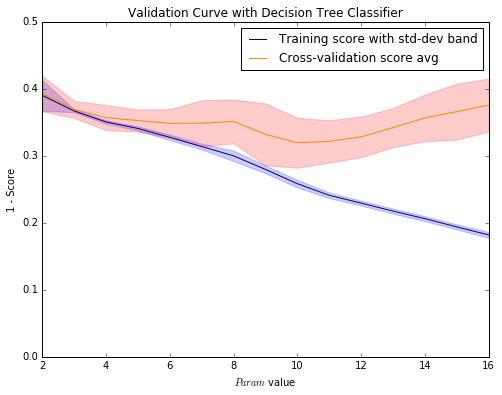

In [69]:
fig, ax = plt.subplots(figsize=(8, 6)) 
plt.title("Validation Curve with Decision Tree Classifier")
plt.xlabel("$Param$ value".format())
plt.ylabel("1 - Score")
plt.ylim(0.0, 0.5)

lw = 1

plt.plot(param_range, train_scores_mean, label="Training score with std-dev band",
             color="navy", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="blue", lw=lw)

plt.plot(param_range, test_scores_mean, label="Cross-validation score avg",
             color="darkorange", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)

plt.legend(loc="best")


## try the same but with logistic regression classifier
valiation curve

In [68]:
# # define our c range to compare
# inv_c_range = np.logspace(-4, 100, 15)

# # param_range = 1./inv_c_range
# param_range = np.linspace(-3,0.5,30)
# # param_range = np.ceil(param_range)
# param_range = np.exp((param_range)*np.log(10))
# param_range


array([  1.00000000e-03,   1.37382380e-03,   1.88739182e-03,
         2.59294380e-03,   3.56224789e-03,   4.89390092e-03,
         6.72335754e-03,   9.23670857e-03,   1.26896100e-02,
         1.74332882e-02,   2.39502662e-02,   3.29034456e-02,
         4.52035366e-02,   6.21016942e-02,   8.53167852e-02,
         1.17210230e-01,   1.61026203e-01,   2.21221629e-01,
         3.03919538e-01,   4.17531894e-01,   5.73615251e-01,
         7.88046282e-01,   1.08263673e+00,   1.48735211e+00,
         2.04335972e+00,   2.80721620e+00,   3.85662042e+00,
         5.29831691e+00,   7.27895384e+00,   1.00000000e+01])

In [ ]:
%%time
train_scores, test_scores = validation_curve(
    LogisticRegression(solver = 'lbfgs', 
                       max_iter = 100,
                      warm_start=True),
    X, Y, 
    param_name="C", 
    param_range=param_range,
    cv=7, 
    scoring='f1', 
    n_jobs=-1)

Process PoolWorker-84:
Process PoolWorker-92:
Process PoolWorker-93:
Process PoolWorker-85:
Process PoolWorker-87:
Process PoolWorker-95:
Process PoolWorker-86:
Process PoolWorker-82:
Process PoolWorker-96:
Process PoolWorker-97:
Process PoolWorker-91:
Process PoolWorker-83:
Process PoolWorker-88:
Process PoolWorker-90:
Process PoolWorker-94:
Process PoolWorker-89:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/

KeyboardInterrupt


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [ ]:
plt.title("Validation Curve with Logistic Regression Classifier")
plt.xlabel("$Param$")
plt.ylabel(" Score")
# plt.ylim(0.0, 10.1)

lw = 1

plt.semilogx(param_range, train_scores_mean, label="Training score with std-dev band",
             color="navy", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="blue", lw=lw)

plt.semilogx(param_range, test_scores_mean, label="Cross-validation score avg",
             color="darkorange", lw=lw)

# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="red", lw=lw)

plt.legend(loc="best")


In [ ]:
finished = True
finished

## Logistic Regression cross validation

show an example of using regularization vs. non-regularizing

In [133]:
param_grid = {
        'penalty': [
                    'l1',
                    'l2',
        ], # type of regularization function norm
            'C': [
                10,
                5,
                1,
                1e-1,
                1e-2,
            ], # the regularization param, the smaller the more regulareized
            'max_iter': [
                        40,
                        100,
                        200,
                        ], # number of descent iterations
    
            "fit_intercept": [ 
                        False, 
                        True,
                            ],# fit the constante intercept
            
               "class_weight": [
                               None,
                            'balanced',
                           ],# if class ratios are as weighted averge when computing the overall loss fn
              }


In [134]:
cardinality  = 1
for key in param_grid.keys():
    cardinality = cardinality*len(param_grid[key])
cardinality


120

In [135]:
lr_no_regularization = True
if lr_no_regularization:
    param_grid['C'] = [1e5]
    param_grid['penalty'] = ['l2']

In [137]:
%%time

start_time = time.time()

num_jobs = -1
# if the training table is too big, fit with a smaller number of CPUs. This in turn
# will take a smaller memory footprint as the dataset's memory won't be replicated for each
# training job
if X.shape[0]>1.5*1e6: num_jobs = 5

logreg  = LogisticRegression( )

clf =GridSearchCV( logreg, 
                  param_grid, 
                  scoring='roc_auc', 
                  fit_params=None,
                  n_jobs=num_jobs, 
                  iid=True, 
                  refit=True, 
                verbose=0, 
                pre_dispatch='2*n_jobs', 
                  error_score='ignore')

clf2 = LogisticRegression()


# when cardinality of grid search is too big, we randomly search for
n_iter_search = 100

if n_iter_search < cardinality:
    clf = RandomizedSearchCV(logreg, param_distributions=param_grid,
                                 n_iter=n_iter_search, n_jobs = num_jobs, verbose=3,
                                       iid=True, refit=True, )

# X = X
# Y = Y.values

clf.fit(X,Y)

elapsed_time =   time.time() - start_time 
print('HyperParam Search took %s seconds to run' % (elapsed_time))


cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, 
                            value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key,
                                        value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1


#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('\n Best estimator was %s \n' % str(clf.best_estimator_))

print('\n Best estimator was %s \n' % str(clf.best_score_))

clf2.set_params(n_jobs = -1,**clf.best_params_)
clf2.fit(X,Y)

elapsed_time =   time.time() - start_time
print('Last Fit took %s seconds to run' % (elapsed_time))

#ojo que esta parte cuando poly ==True no funciona..

Fitting 3 folds for each of 100 candidates, totalling 300 fits


ValueError: The total space of parameters 12 is smaller than n_iter=100. For exhaustive searches, use GridSearchCV.

In [ ]:
best_params

# REST of shit

### Count Featurizer on Antennas
nos quedamos con las columnas de antennas y en graphlab aplicamos el algo de CountFeaturizer para cada categoria de
Antenna_ID_N


In [ ]:
%%time
import graphlab as gl
from graphlab.toolkits.feature_engineering import *
ant_cols = [col for col in X_train.columns if "ANTENNA_ID" in col]
ant_sframe_fit = gl.SFrame(X_fit[ant_cols + ['y']])
ant_sframe_train = gl.SFrame(X_train[ant_cols + ['y']])
ant_sframe_val = gl.SFrame(X_val[ant_cols + ['y']])

In [ ]:
%%time
countfeat = gl.feature_engineering.create(ant_sframe_fit, 
               CountFeaturizer(target='y'))

# Transform the train set. This is the dataset I will train my classifier on
transformed_ant_train = countfeat.transform(ant_sframe_train)
transformed_ant_val = countfeat.transform(ant_sframe_val)

del ant_sframe_fit,ant_sframe_train,ant_sframe_val

#por alguna razon guarda los valores de probabilidad como una lista de un unico valor
for col in [col for col in transformed_ant_train.column_names() if "prob_" in col]:
    transformed_ant_train[col] = transformed_ant_train[col].apply(lambda x: x[0]) 
    transformed_ant_val[col] = transformed_ant_val[col].apply(lambda x: x[0]) 

#me quedo solo con los valores de probabilidad.
transformed_ant_train = transformed_ant_train[[col for col in transformed_ant_train.column_names() if "prob_" in col]]
transformed_ant_val = transformed_ant_val[[col for col in transformed_ant_train.column_names() if "prob_" in col]]

transformed_ant_val = transformed_ant_val.to_dataframe()
transformed_ant_train = transformed_ant_train.to_dataframe()

In [ ]:
X_val[ant_cols] = transformed_ant_val.values
X_train[ant_cols] = transformed_ant_train.values
del transformed_ant_train, transformed_ant_val

### Cross Validate SGD

In [ ]:
param_grid = [
  { 'alpha': [1e-3,5*1e-3,1e-2], 'l1_ratio': [3*1e-2,1e-3,6*1e-4], 'n_iter': [2,3]
  }
    ]

In [37]:
start_time = time.time()

param_grid = [
  { 'alpha': [1e-3,5*1e-3,1e-2], 'l1_ratio': [3*1e-2,1e-3,6*1e-4], 'n_iter': [2,3]
  }
    ]
sgd = SGDClassifier(loss='modified_huber', penalty='elasticnet', 
             fit_intercept=True,  shuffle=True, 
                    n_jobs=3,learning_rate='optimal', power_t =2, eta0 =5,
                    class_weight='balanced', average=40)

clf =GridSearchCV(sgd, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)



predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['class'] = clf.predict(X_test)
predicted_proba[gt] =  y_test
predicted_proba.sort_values(by = 'prob',ascending = False, inplace = True)

cut_percentages = [10,20,30,40]
#converted = (predicted_proba['class']==1)
#me fijo todos los users que van a convertir en el futuro


start = 0
mobility_dict = {}
index_segments = []
for i in cut_percentages:
    cut_size = int(len(predicted_proba)*i/100.0)    
    bool_array = (~np.ones(len(predicted_proba), dtype=bool))
    bool_array[start: start + cut_size] = True
    index_segments += [bool_array]
    start = start + cut_size
#    subtable = 
    #mobility_dict[str(i)] = predicted_proba.loc[index_segments[-1],'ref_hash']
    
    print(classification_report(predicted_proba.loc[index_segments[-1],gt].values,
                            predicted_proba.loc[index_segments[-1],'class'].values ))
    
    
print(classification_report(predicted_proba.loc[:,gt].values,
                            predicted_proba.loc[:,'class'].values ))
    
    
cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

all_time =   time.time() - start_time

#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('This cell took %s seconds to run' % all_time)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] n_iter=2, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] n_iter=2, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.001, l1_ratio=0.03, score=0.125354 -   2.5s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.001, l1_ratio=0.03, score=0.127442 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.001, l1_ratio=0.03, score=0.119463 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.001, l1_ratio=0.03, score=0.132910 -   3.1s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.001, l1_ratio=0.03, score=0.133858 -   3.1s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.001, l1_ratio=0.03, score=0.125862 -   3.1s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.001, l1_ratio=0.001, score=0.114065 -   2.5s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.001, l1_ratio=0.001, score=0.125576 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.001, l1_ratio=0.001, score=0.125882 -   2.8s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.001, l1_ratio=0.001, score=0.138072 -   3.3s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.001, l1_ratio=0.001, score=0.133482 -   3.1s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.001, l1_ratio=0.001, score=0.133945 -   3.2s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.124318 -   2.5s
[CV] n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.125224 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.129423 -   2.5s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.131845 -   3.1s
[CV] n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.135827 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.001, l1_ratio=0.0006000000000000001, score=0.128485 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.005, l1_ratio=0.03, score=0.125477 -   2.4s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.005, l1_ratio=0.03, score=0.125957 -   2.8s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.005, l1_ratio=0.03, score=0.127511 -   2.6s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.005, l1_ratio=0.03, score=0.127618 -   2.8s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.03 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.005, l1_ratio=0.03, score=0.125386 -   2.8s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.005, l1_ratio=0.03, score=0.136983 -   3.0s


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   47.9s


[CV] n_iter=2, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.005, l1_ratio=0.001, score=0.120290 -   2.5s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.005, l1_ratio=0.001, score=0.118753 -   2.5s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=2, alpha=0.005, l1_ratio=0.001, score=0.127159 -   2.9s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.005, l1_ratio=0.001, score=0.127485 -   3.3s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.001 ...........................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.005, l1_ratio=0.001, score=0.139728 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .. n_iter=3, alpha=0.005, l1_ratio=0.001, score=0.130469 -   3.1s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.129161 -   2.5s
[CV] n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.130159 -   2.5s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.127613 -   2.5s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.132956 -   3.1s
[CV] n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001 ...........


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.143005 -   3.1s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.005, l1_ratio=0.0006000000000000001, score=0.135926 -   3.1s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=2, alpha=0.01, l1_ratio=0.03, score=0.128098 -   2.4s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=2, alpha=0.01, l1_ratio=0.03, score=0.127078 -   2.7s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=2, alpha=0.01, l1_ratio=0.03, score=0.126921 -   2.5s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=3, alpha=0.01, l1_ratio=0.03, score=0.138152 -   3.6s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.03 .............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=3, alpha=0.01, l1_ratio=0.03, score=0.106208 -   3.1s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] .... n_iter=3, alpha=0.01, l1_ratio=0.03, score=0.143076 -   2.8s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.01, l1_ratio=0.001, score=0.132427 -   2.5s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.01, l1_ratio=0.001, score=0.125901 -   2.9s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=2, alpha=0.01, l1_ratio=0.001, score=0.128001 -   2.7s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.01, l1_ratio=0.001, score=0.135568 -   3.1s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.001 ............................


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] ... n_iter=3, alpha=0.01, l1_ratio=0.001, score=0.132579 -   4.4s
[CV] ... n_iter=3, alpha=0.01, l1_ratio=0.001, score=0.136589 -   3.7s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.124134 -   2.8s
[CV] n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.130883 -   2.5s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=2, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.122741 -   3.5s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001 ............


/home/ubuntu/Virtualenvs/mateo/lib/python3.4/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.132433 -   3.7s
[CV] n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001 ............
[CV]  n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.135111 -   3.4s
[CV]  n_iter=3, alpha=0.01, l1_ratio=0.0006000000000000001, score=0.135908 -   3.1s


[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.7min finished


             precision    recall  f1-score   support

          0       1.00      0.31      0.47    355992
          1       0.06      0.99      0.11     15152

avg / total       0.96      0.33      0.45    371144

This cell took 108.56432461738586 seconds to run


In [ ]:
threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'y'].values,predicted_proba.loc[ind,'class'].values ))

In [38]:
clf.best_estimator_

SGDClassifier(alpha=0.005, average=40, class_weight='balanced', epsilon=0.1,
       eta0=5, fit_intercept=True, l1_ratio=0.0006000000000000001,
       learning_rate='optimal', loss='modified_huber', n_iter=3, n_jobs=3,
       penalty='elasticnet', power_t=2, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [39]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

n_iter
2.0    0.125741
3.0    0.132943
Name: mean_score, dtype: float64
n_iter
2.0    0.002609
3.0    0.002703
Name: mean_score, dtype: float64


### Results
* l1_ratio = cuanto mas chico mejor con lo cual la perdida l2 parece ser mejor
* alpha = 1e-3 es suficiente pues casi no afecta el score
* power_t = muy variado, no parece haber correlacion entre el tamanyo y el avg, mean_score
* eta0 = no afecta mucho pero parece ser que con ser >1 ya esta
* power_t = parecen ser practicamente iguales
* n_iter = cuanto mas iter NO mejora el score

In [51]:
len(predicted_proba)

371161

## Cross Validate NN

In [35]:
start_time = time.time()

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

param_grid = { 'alpha': [1e-1,5*1e-2,1e-2],
              'hidden_layer_sizes':[(50,),(15,5)],
              'learning_rate': ['adaptive',"invscaling"],
              "algorithm": ['adam'],'momentum': [1e-2, 1e-1, 0.5],
  'power_t': [1e-3, 5*1e-4, 1e-5], 'activation':['logistic','relu']
 }

mlp = MLPClassifier(shuffle=True, 
                 verbose=True)

clf =GridSearchCV(mlp, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive 
Iteration 1, loss = 0.20405210
Iteration 1, loss = 0.20380843
Iteration 1, loss = 0.20378706
Iteration 1, loss = 0.20405210


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.5s
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive 


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.7s


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   2.1s


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.9s


KeyboardInterrupt: 

In [1]:
clf.best_estimator_

NameError: name 'clf' is not defined

In [52]:
# compare best parameters to tune
coln=1
cv_result.groupby(cv_result.columns[coln])['mean_score'].mean()
cv_result.groupby(cv_result.columns[coln])['mean_score'].std()

alpha
0.00     0.000007
0.01     0.000007
0.10     0.000007
0.50     0.000007
1.00     0.000007
10.00    0.000007
Name: mean_score, dtype: float64

### Results
* activation = logistic es 10% mejor
* alpha = 1e-2 el mejor 
* power_t = cuanto mas chico mejor, 1e-3 por lo menos
* hidden_layer_size = menos layers es mejor..?
* power_t = parecen ser practicamente iguales
* n_iter = cuanto mas iter NO mejora el score

## Bernoulli RBM features selection & Logit crossval

In [127]:
start_time = time.time()

## obs. este metodo es especial y asume que todos los valores son True/False o que \in [0,1]
# luego tengo que pensar en como tomar los features nuevamente.
# tampoco 'fittea' en la forma tradicional. Sino que se le puede tomar al y como un feature mas y esta red
# va 'modificando' todos los valores del X (minimizando la entropia) para dar un output. Luego corriendo 
# clf.gibbs(X_test) con el y_test como feature tmb, nos transforma la data para ver el output como la 'prediccion'
# obviamente no tiene probabilidades


#X = X_train[X_cols].values
#y = X_train['ground_truth'].values

df = X_train.drop(X_train[X_train[X_train.columns[0:3]].\
                                   sum(axis=1)==0].index)
df = df[X_cols + ['ground_truth']]

for col in X_train.columns[0:3]:
    df[col] = df[col]*1.0/df[df.columns[0:3]].sum(axis=1)

df[df.columns[3]] =  df[df.columns[3]]/df[df.columns[3]].max()
df[df.columns[4]] =  df[df.columns[4]]/df[df.columns[4]].max()

X = df[df.columns[:-1]].values
y = df['ground_truth'].values


param_grid = {'rbm__n_components': [256, 128,46,10],
   'rbm__n_iter':[15,10,5], 'rbm__learning_rate': [1e-4,1e-3,1e-2,1e-1,5*1e-3,5*1e-2,5*1e-1],
  'rbm__batch_size': [10e4,3*10e3, 1e3, 300],"logistic__C": [1.0, 10.0, 100.0] 
 }

rbm = BernoulliRBM(verbose=True)
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

clf =GridSearchCV(classifier, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

#este metodo NO tiene predicted proba, lo que hacemos es recorrer 
#predicted_labels = rbm.gibbs(X_test)[:,-1]
#real_labels = X_test[:,-1]
#print(classification_report(real_labels,predicted_labels ))


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))
all_time =   time.time() - start_time

finished = True

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
    
print('This cell took %s seconds to run' % all_time)


KeyboardInterrupt: 

In [ ]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

In [23]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


criterion
gini    0.802919
Name: mean_score, dtype: float64
criterion
gini    0.000598
Name: mean_score, dtype: float64


## CrossV SVC

In [ ]:
start_time = time.time()

param_grid = [{'kernel': ['rbf'], 'gamma': list(10.0 ** np.arange(-2, 3)),
                     'C': list(10.0 ** np.arange(0, 4))},
                    {'kernel': ['poly'], 'C': list(10.0 ** np.arange(0, 4)), 'degree'[2,3,4]}]

svc = SVC(shuffle=True, probability=True,decision_function_shape = 'ovr',
           verbose=True, class_weight='balanced'
          )

clf =GridSearchCV(svc, param_grid, scoring='roc_auc', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

In [ ]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


In [214]:
#tomo tiempo para saber cuanto tarda fitear el estimador
start_time = time.time()

#model = model.fit(X,y,sample_weight=W)

W = np.array([10 if i == 1 or i ==2  else 1 for i in y_mini])
gradboost.fit(X_mini,y_mini, sample_weight=W)

elapsed_time =   time.time() - start_time
print('GradientBoosting took %s seconds to run' % elapsed_time)

#validated =  cross_val_score(gradboost,X,y,cv=5, scoring = "f1_weighted")


all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

GradientBoosting took 117.26272392272949 seconds to run
This cell took 117.26284193992615 seconds to run


## Timings
* 5s con  10 n_estimadores, 15 max_depth y X.sample(0.2)
* 15s con 10 n_estimadores, 15 max_depth y X.sample(0.2)
* 47s con 10 n_estimadores, 15 max_depth y X.sample(0.4)
* 35s con 10 n_estimadores, 15 max_depth y X.sample(0.4)
* 117 con 20 n_estimadores, 20 max_depth y X.sample(0.4)

In [31]:
X_train['ground_truth'].value_counts()

0    128153
1      7064
Name: ground_truth, dtype: int64

### Results
* NO escalar (normalizar, restar la media  dividir por la std, etc) los resultados pues REVIENTAN los scores.
* bootstrap  = False es 5% mejor
* min_samples_leaf = mas chico es claramente mejor, pero tmb aumenta el overfitting lo cual me hace caer mucho el valor del recall en el test_set. Sin embargo es un parametro muy sensible en la precision. Resta evaluar asi el tradeoff entre la precision y el volumen de users al cual queremos llegar.
* n_estimators = aumentar mas de 30 no tendria mucho sentido
* citerion = entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features = no afecta al score. con auto esta bien
* max_depth =  mas es mejor. intentaria probar con >15

In [ ]:
%%time
#con decomposicion qr tratamos de ver si existe alguna columna que sea comb linear de las demas
linear_test = np.linalg.qr(X_train.sample(1e6))[1]
#notar que devuelve la tabla de tamanyo N`columnas x Ncolumnas

#sumo a traves de las columnas para que me de el valor absoluto sumado de c/fila
linear_test = abs(linear_test.sum(axis=1))<1e-2
#si hubiese alguan que sea linearcomb entonces tendria que aparecer que toda la fila es de ceros
for i, col in enumerate(X_train.columns):
    if linear_test[i] == True:
        print(col)

# Todo
* evaluate hit_rate and 
* tune adaboost, bernoulliRBM
* xgboost
* libffm
* SVC muy lento.. speed up in AWS
